# Objectives

1. Import
2. Classifier
   a. Train on Real, Test on Holdout
   b. Train on Synth, Test on Holdout
3. Calculate Metrics
   a. Selection Rate: prior ML, ML_real, ML_synth
   b. Demographic Parity (Statistical Parity Difference): Unterschiede in W'keit, dass Pers. verschiedener Subgruppen auf ICU aufgenommen werden?
   c. Equal Opportunity Difference (True Positive Rate Difference): Unterschiedliche W'keiten hinsichtlich ICU-Prediction je nach Subgruppe?
   d. Equalized Odds: Unterschiede sowohl in TPR als auch FPR zwischen Subgruppen
   e. Predictive Parity (Positive Predictive Value Difference): Variiert die PPV für unterschiedliche Subgruppen? (Gleich sichere VOrhersage für alle Gruppen?)
4. SHAP-Values
5. LIME-Values for 2 Patients
   

# Imports

In [51]:
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from typing import Union, Optional, Tuple
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    confusion_matrix, classification_report,
    precision_recall_curve, precision_score, recall_score,
    average_precision_score, roc_curve
)
import shap
from typing import Optional
from lime.lime_tabular import LimeTabularExplainer
from fairlearn.metrics import (
    MetricFrame, selection_rate, demographic_parity_difference, 
    equalized_odds_difference, false_positive_rate, 
    true_positive_rate, equal_opportunity_difference, count
)




# User Configuration

In [54]:
# File paths – consider loading these from a config or CLI for flexibility
REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

# Define directories for input and output
DATA_DIR = Path("../../data")
FIG_DIR = Path("figures")
RES_DIR = Path("results")
CACHE_DIR = Path("cache")

SAVE_FIGURES = True
RANDOM_SEED = 42

# Age group bins and labels (should match domain requirements)
AGE_BINS = [-np.inf, 29, 60, np.inf]
AGE_LABELS = ["<30", "30-60", ">60"]

# Define sensitive features for fairness analysis
SENSITIVE_FEATURES = ["gender", "ethnicity", "age_group"]

# Set seaborn style for plots
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions
## Data Loading

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Plotting

In [4]:

def plot_selection_rate_heatmap_by_gender(
    df: pd.DataFrame,
    gender_col: str = "gender",
    x_col: str = "ethnicity",
    y_col: str = "age_group",
    value_col: str = "selection_rate",
    cmap: Optional[str] = "viridis",
    diverging: bool = False,
    annot: bool = True,
    fmt: str = ".2f",
    cbar: bool = True,
    height: float = 4,
    width: float = 3,
    custom_scale: Optional[Tuple[float, float]] = None,
    aspect: float = 1.2,
) -> plt.Figure:
    """
    Plot selection‐rate heatmaps faceted by gender.

    This expects `df` to have one row per subgroup with columns:
      - gender_col  (e.g. "Male", "Female", ...)
      - x_col       (e.g. ethnicity categories)
      - y_col       (e.g. age_group categories)
      - value_col   (the numeric selection_rate)

    Args:
        df: DataFrame with intersectional subgroup metrics.
        gender_col: column name to facet on (one heatmap per unique value).
        x_col: column to use for heatmap’s x-axis (columns of the matrix).
        y_col: column to use for heatmap’s y-axis (rows of the matrix).
        value_col: the cell value to plot (heat intensity).
        cmap: matplotlib colormap name.
        annot: whether to annotate cells with their values.
        fmt: format string for annotations.
        cbar: whether each facet gets its own colorbar.
        height: height (in inches) of each facet.
        aspect: aspect ratio (width/height) of each facet.

    Returns:
        The Seaborn FacetGrid instance (so you can further tweak or save it).
    """
    # Ensure required columns are present
    missing = {gender_col, x_col, y_col, value_col} - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns in DataFrame: {missing!r}")

    # compute common color‐scale limits
    raw_min = df[value_col].min()
    raw_max = df[value_col].max()
    if diverging:
        abs_max = max(abs(raw_min), abs(raw_max))
        vmin, vmax = -abs_max, +abs_max
    else:
        vmin, vmax = raw_min, raw_max

    if custom_scale is not None:
        if len(custom_scale) != 2:
            raise ValueError("custom_scale must be a tuple of (min, max)")
        vmin, vmax = custom_scale

    # Create the FacetGrid: one facet per gender
    grid = sns.FacetGrid(
        df,
        col=gender_col,
        sharex=True,
        sharey=True,
        aspect=aspect,
        col_wrap=1,
    )

    # Define the per‐facet heatmap function
    def _draw_heatmap(data: pd.DataFrame, **kwargs):
        # Pivot to matrix form
        pivot = data.pivot(index=y_col, columns=x_col, values=value_col).reindex(AGE_LABELS)
        sns.heatmap(
            pivot,
            annot=annot,
            fmt=fmt,
            cbar=cbar,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            center=0 if diverging else None,
            **kwargs,
        )

    # Map it onto the grid
    grid.map_dataframe(_draw_heatmap)

    # Label axes
    grid.set_axis_labels(x_col, y_col)

    grid.figure.set_size_inches(width, height)

    # Tight layout for nicer spacing
    plt.tight_layout()

    return grid.figure


# Main Routine

## Daten Vorbereiten
### Einlesen

In [ ]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)
df_holdout = df_holdout.dropna().reset_index(drop=True)

### Unique Kategorien für Encoder bestimmen und Col-Datatypes

In [6]:
df_combined = pd.concat([df_real, df_synth], ignore_index=True).reset_index(drop=True) # Holdout gezielt nicht

num_cols = df_combined.select_dtypes(include='number').columns.tolist()

cat_cols = df_combined.select_dtypes(include=['category', 'bool']).columns.drop(
    ['consciousness_level','news_score', 'icu_admission_24h']
).tolist()
ord_cols = ['consciousness_level','news_score']

cat_categories = {
    col: sorted(df_combined[col].dropna().unique().tolist())
    for col in cat_cols
}
ord_categories = {col: df_combined[col].cat.categories.tolist() for col in ord_cols}

### Target Column und Data Split
Cave: weil ein Holdout-Datensatz vorhanden ist, findet kein train-test-split wie sonst statt sondern test wird/ist durch Holdout definiert

In [7]:
target = "icu_admission_24h"

X_real,    y_real    = df_real.drop(columns=target),    df_real[target]
X_synth,   y_synth   = df_synth.drop(columns=target),   df_synth[target]
X_holdout, y_holdout = df_holdout.drop(columns=target), df_holdout[target]


## Random Forest-Logik

In [8]:
# preprocess = ColumnTransformer([
#     ('num', StandardScaler(), num_cols),
#     ('cat', OneHotEncoder(
#             categories=[cat_categories[c] for c in cat_cols],
#             handle_unknown='ignore',
#             sparse_output=False
#         ),
#     cat_cols),
#     ('ord', OrdinalEncoder(
#             categories=[ord_categories[c] for c in ord_cols],
#             handle_unknown='use_encoded_value',
#             unknown_value=-1
#         ),
#     ord_cols)
# ], remainder="drop")

# rf_params = {
#     'n_estimators': 200,
#     'max_depth': 8,
#     'min_samples_split': 10,
#     'min_samples_leaf': 5,
#     'max_features': 'sqrt',
#     'class_weight': 'balanced_subsample',
#     'oob_score': True,
#     'n_jobs': -1,
#     'random_state': RANDOM_SEED
# }

# rf_clf = RandomForestClassifier(**rf_params)

# model = Pipeline(steps=[
#     ("prep", preprocess),
#     ("clf",  rf_clf)
# ])


In [9]:
# 1) Preprocessing
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(
            categories=[cat_categories[c] for c in cat_cols],
            handle_unknown='ignore',
            sparse_output=False
        ),
     cat_cols),
    ('ord', OrdinalEncoder(
            categories=[ord_categories[c] for c in ord_cols],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ),
     ord_cols)
], remainder="drop")

# 2) Basis-Estimator
rf_params = {
    'n_estimators': 200,
    'max_depth': 8,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'class_weight': 'balanced_subsample',
    'oob_score': True,
    'n_jobs': 1, # +1 ist korrekt; -1 nur bei GridSearch, da sonst Oversubscription!
    'random_state': RANDOM_SEED
}
rf_clf = RandomForestClassifier(**rf_params)

# 3) Pipeline
model = Pipeline([
    ("prep", preprocess),
    ("clf",  rf_clf)
])

# 4) CV-Strategie
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

# # 5) Baseline CV (optional) ca. 1 min
# # CV-Mittelwerte (real): {'accuracy': np.float64(0.7434725697651496), 'roc_auc': np.float64(0.7781028363405531), 'f1': np.float64(0.383299986026956)}
# scoring = {'accuracy':'accuracy', 'roc_auc':'roc_auc', 'f1':'f1'}
# cv_results = cross_validate(
#     estimator=model,
#     X=X_real,        # oder X_synth für synthetische Daten
#     y=y_real,        # bzw. y_synth
#     cv=cv,
#     scoring=scoring,
#     n_jobs=-1
# )
# print("CV-Mittelwerte (real):",
#       {m: np.mean(cv_results[f'test_{m}']) for m in scoring})

# 6) Hyperparameter-Raster
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth':    [6, 8, 10],
    'clf__min_samples_leaf': [3, 5]
}



### GridSearch

In [10]:
# 7) GridSearch für reales Training, 10 Min
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# Best Params (real): {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 200}
# Best CV ROC-AUC (real): 0.7831072545669022

grid_real = GridSearchCV(
    estimator=clone(model),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
)
grid_real.fit(X_real, y_real)
print("Best Params (real):", grid_real.best_params_)
print("Best CV ROC-AUC (real):", grid_real.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params (real): {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 200}
Best CV ROC-AUC (real): 0.7831072545669022


In [11]:
# 8) GridSearch für synthetisches Training, 8 min
# Fitting 5 folds for each of 12 candidates, totalling 60 fits
# Best Params (synth): {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 100}
# Best CV ROC-AUC (synth): 0.8569688251770694

grid_synth = GridSearchCV(
    estimator=clone(model),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3
)
grid_synth.fit(X_synth, y_synth)
print("Best Params (synth):", grid_synth.best_params_)
print("Best CV ROC-AUC (synth):", grid_synth.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Params (synth): {'clf__max_depth': 10, 'clf__min_samples_leaf': 5, 'clf__n_estimators': 100}
Best CV ROC-AUC (synth): 0.8569688251770694


In [12]:
best_model_real  = grid_real.best_estimator_
best_model_synth = grid_synth.best_estimator_

### Export Trained Models

In [52]:
# ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ts = datetime.now().strftime("%Y%m%d")

cache_path = CACHE_DIR / f"model_real_cache_{ts}.pkl"
cache_path.parent.mkdir(parents=True, exist_ok=True)

with cache_path.open("wb") as f:
    pickle.dump(best_model_real, f)
print(f"Ergebnis gecached in {cache_path}")

cache_path = CACHE_DIR / f"model_synth_cache_{ts}.pkl"
cache_path.parent.mkdir(parents=True, exist_ok=True)
with cache_path.open("wb") as f:
    pickle.dump(best_model_synth, f)
print(f"Ergebnis gecached in {cache_path}")

Ergebnis gecached in cache\model_real_cache_20250518.pkl
Ergebnis gecached in cache\model_synth_cache_20250518.pkl


### (Optional) Load Pretrained Models

In [53]:
# name_real = "model_real_cache_20250518.pkl"
# cache_path = CACHE_DIR / name_real
# if cache_path.exists():
#     with cache_path.open("rb") as f:
#         best_model_real = pickle.load(f)
#     print("Pretrained real model loaded from cache")


# name_synth = "model_synth_cache_20250518.pkl"
# cache_path = CACHE_DIR / name_synth
# if cache_path.exists():
#     with cache_path.open("rb") as f:
#         best_model_synth = pickle.load(f)
#     print("Pretrained synth model loaded from cache")



Pretrained real model loaded from cache
Pretrained synth model loaded from cache


### Quality Scores

In [13]:
y_pred_real = best_model_real.predict(X_holdout)
print("Holdout F1 (real):", f1_score(y_holdout, y_pred_real))
print("ROC-AUC (real):", grid_real.best_score_)

y_pred_synth = best_model_synth.predict(X_holdout)
print("Holdout F1 (synth):", f1_score(y_holdout, y_pred_synth))
print("ROC-AUC (synth):", grid_synth.best_score_)

Holdout F1 (real): 0.3806444162143435
ROC-AUC (real): 0.7831072545669022
Holdout F1 (synth): 0.31861132498075173
ROC-AUC (synth): 0.8569688251770694


In [14]:


# # a) auf Real-Daten
# model_real  = clone(model)           # sklearn.clone, um frische Kopie zu erhalten
# model_real.fit(X_real, y_real)
# #
# # b) auf Synthetic-Daten
# model_synth = clone(model)
# model_synth.fit(X_synth, y_synth)


In [15]:


proba = best_model_real.predict_proba(X_holdout)[:,1]
prec, rec, thr = precision_recall_curve(y_holdout, proba)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_thr_real = thr[np.argmax(f1_scores)]
print("Optimale Schwelle:", best_thr_real)

Optimale Schwelle: 0.5623751899905541


In [16]:


proba = best_model_synth.predict_proba(X_holdout)[:,1]
prec, rec, thr = precision_recall_curve(y_holdout, proba)
f1_scores = 2 * (prec * rec) / (prec + rec)
best_thr_synth = thr[np.argmax(f1_scores)]
print("Optimale Schwelle:", best_thr_synth)

Optimale Schwelle: 0.4640450060830271


In [17]:


def evaluate(name, fitted_model, user_proba):
    proba = fitted_model.predict_proba(X_holdout)[:, 1]
    pred  = (proba >= user_proba).astype(int)       # Schwelle ggf. justieren

    print(f"=== {name} ===")
    print("Accuracy :", accuracy_score(y_holdout, pred))
    print("F1-Score :", f1_score(y_holdout, pred))
    print("ROC AUC  :", roc_auc_score(y_holdout, proba))
    print(confusion_matrix(y_holdout, pred))
    print(classification_report(y_holdout, pred))


In [18]:
evaluate("Real-modell",   best_model_real, user_proba=best_thr_real)
evaluate("Synth-modell",  best_model_synth, user_proba=best_thr_synth)


=== Real-modell ===
Accuracy : 0.8393425490475512
F1-Score : 0.40342212030340446
ROC AUC  : 0.7779423043347391
[[33051  3860]
 [ 2904  2287]]
              precision    recall  f1-score   support

       False       0.92      0.90      0.91     36911
        True       0.37      0.44      0.40      5191

    accuracy                           0.84     42102
   macro avg       0.65      0.67      0.66     42102
weighted avg       0.85      0.84      0.85     42102

=== Synth-modell ===
Accuracy : 0.7424350387155004
F1-Score : 0.3228425128012989
ROC AUC  : 0.6878660124325251
[[28673  8238]
 [ 2606  2585]]
              precision    recall  f1-score   support

       False       0.92      0.78      0.84     36911
        True       0.24      0.50      0.32      5191

    accuracy                           0.74     42102
   macro avg       0.58      0.64      0.58     42102
weighted avg       0.83      0.74      0.78     42102



#### ROC-AUC

In [19]:
# 1. Vorhersage-Wahrscheinlichkeiten holen
proba_real  = best_model_real.predict_proba(X_holdout)[:, 1]
proba_synth = best_model_synth.predict_proba(X_holdout)[:, 1]

# 2. ROC-Kurven berechnen
fpr_real, tpr_real, _    = roc_curve(y_holdout, proba_real)
fpr_synth, tpr_synth, _  = roc_curve(y_holdout, proba_synth)

# 3. AUC-Werte
auc_real  = roc_auc_score(y_holdout, proba_real)
auc_synth = roc_auc_score(y_holdout, proba_synth)

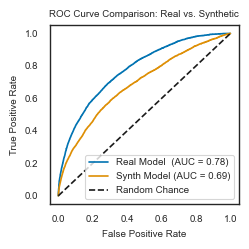

In [20]:
plt.figure(figsize=(2.5, 2.5))
plt.plot(fpr_real,  tpr_real,  label=f'Real Model  (AUC = {auc_real:.2f})')
plt.plot(fpr_synth, tpr_synth, label=f'Synth Model (AUC = {auc_synth:.2f})')
plt.plot([0, 1],    [0, 1],    'k--', label='Random Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Real vs. Synthetic')
plt.legend(loc='lower right')
plt.tight_layout()
if SAVE_FIGURES:
    fname = f'bias_ml_ROC-curve.tiff'
    fullpath = FIG_DIR / f'{fname}'
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
    
plt.show()

#### Precision-Recall Curve

In [21]:
# 1. Vorhersage-Wahrscheinlichkeiten holen
proba_real  = best_model_real.predict_proba(X_holdout)[:, 1]
proba_synth = best_model_synth.predict_proba(X_holdout)[:, 1]

# 2. Precision-Recall-Kurven berechnen
prec_real, rec_real, _    = precision_recall_curve(y_holdout, proba_real)
prec_synth, rec_synth, _  = precision_recall_curve(y_holdout, proba_synth)

# 3. Average Precision-Werte
ap_real  = average_precision_score(y_holdout, proba_real)
ap_synth = average_precision_score(y_holdout, proba_synth)



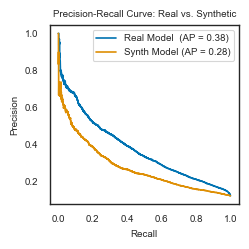

In [22]:
plt.figure(figsize=(2.5, 2.5))
plt.plot(rec_real,  prec_real,  label=f'Real Model  (AP = {ap_real:.2f})')
plt.plot(rec_synth, prec_synth, label=f'Synth Model (AP = {ap_synth:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Real vs. Synthetic')
plt.legend(loc='upper right')
plt.tight_layout()
if SAVE_FIGURES:
    fname = f'bias_ml_precision-recall-curve.tiff'
    fullpath = FIG_DIR / f'{fname}'
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
    
plt.show()

#### Tabelle

In [23]:
y_pred_real  = best_model_real.predict(X_holdout)
y_pred_synth = best_model_synth.predict(X_holdout)
proba_real   = best_model_real.predict_proba(X_holdout)[:,1]
proba_synth  = best_model_synth.predict_proba(X_holdout)[:,1]

# 2) Sammle die Metriken
data = {
    'Model': ['Real', 'Synthetic'],
    'Accuracy': [
        accuracy_score(y_holdout, y_pred_real),
        accuracy_score(y_holdout, y_pred_synth)
    ],
    'Precision': [
        precision_score(y_holdout, y_pred_real),
        precision_score(y_holdout, y_pred_synth)
    ],
    'Recall': [
        recall_score(y_holdout, y_pred_real),
        recall_score(y_holdout, y_pred_synth)
    ],
    'F1-Score': [
        f1_score(y_holdout, y_pred_real),
        f1_score(y_holdout, y_pred_synth)
    ],
    'ROC AUC': [
        roc_auc_score(y_holdout, proba_real),
        roc_auc_score(y_holdout, proba_synth)
    ]
}

df_metrics = pd.DataFrame(data)
display(df_metrics)
if SAVE_FIGURES:
    fname = f'bias_ml_model-metrics-compared.csv'
    fullpath = RES_DIR / f'{fname}'
    df_metrics.to_csv(
        fullpath,
        index=False,
        sep=';',
        decimal=',',
        encoding='utf-8'
    )
    print(f"CSV gespeichert unter: {fullpath}")

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Real,0.745238,0.27179,0.634945,0.380644,0.777942
1,Synthetic,0.768776,0.25022,0.438451,0.318611,0.687866


# Fairness Metrics

In [24]:
def add_age_group_column(df, col="age", new_col="age_group"):
    """Cut age into three bins."""
    df[new_col] = pd.cut(df[col], bins=AGE_BINS, labels=AGE_LABELS, right=False)

def add_subgroup_key(df, sensitive_columns, new_col="subgroup_key"):
    """Create a subgroup key based on sensitive features."""
    subgroup_key = (
        df[list(sensitive_columns)]
        .astype(str)
        .agg("_".join, axis=1)
        .rename(new_col)
    )
    df[new_col] = subgroup_key

In [25]:
df_holdout['icu_pred_real'] = best_model_real.predict(X_holdout)
df_holdout['icu_pred_synth'] = best_model_synth.predict(X_holdout)

add_age_group_column(df_holdout, col="age", new_col="age_group")

In [26]:
sensitive_columns = ["gender", "ethnicity", "age_group"]

add_subgroup_key(df_holdout, sensitive_columns, new_col="subgroup_key")

## Für Real

In [27]:
y_true = df_holdout["icu_admission_24h"]
y_pred_real = df_holdout["icu_pred_real"]
sens_test = df_holdout['subgroup_key']

metric_frame_real = MetricFrame(metrics={
    'Selection Rate': selection_rate,
    'True Positive Rate': true_positive_rate,
    'False Positive Rate': false_positive_rate,
    'Count': count
},
y_true=y_true,
y_pred=y_pred_real,
sensitive_features=sens_test)
metric_frame_real.by_group

,Selection Rate,True Positive Rate,False Positive Rate,Count
subgroup_key,,,,
F_Asian_30-60,0.186047,0.500000,0.151292,301.0
F_Asian_<30,0.229167,0.666667,0.215054,96.0
F_Asian_>60,0.279683,0.641509,0.220859,379.0
F_Black_30-60,0.212138,0.565217,0.176654,1763.0
F_Black_<30,0.166181,0.400000,0.143770,343.0
F_Black_>60,0.267342,0.590090,0.226469,1975.0
F_Other_30-60,0.208141,0.590909,0.174220,1081.0
F_Other_<30,0.168539,0.473684,0.145161,267.0
F_Other_>60,0.281319,0.575758,0.245376,910.0


In [28]:
df_prepped = metric_frame_real.by_group.reset_index()

# Split the subgroup_key into parts
df_prepped[['gender', 'ethnicity', 'age_group']] = df_prepped['subgroup_key'].str.extract(r'^(?P<gender>[MF])_(?P<ethnicity>[^_]+)_(?P<age_group>.+)$')

# Optional: make gender labels nicer (z.B. F -> Female)
df_prepped['gender'] = df_prepped['gender'].map({'F': 'Female', 'M': 'Male'})

# Rename columns if needed to match the plot function’s expected naming
df_prepped = df_prepped.rename(columns={
    'Selection Rate': 'selection_rate'
})

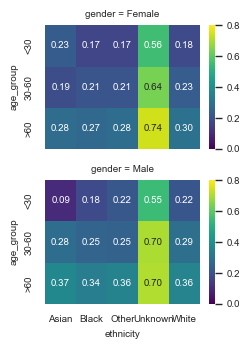

In [29]:
fig = plot_selection_rate_heatmap_by_gender(
    df=df_prepped,
    gender_col='gender',
    x_col='ethnicity',
    y_col='age_group',
    value_col='selection_rate',
    height=3.5,
    width=2.5,
    custom_scale=(0, 0.8)
)
plt.show()
if SAVE_FIGURES:
    fname = f'bias_ml_fairness_real.tiff'
    fullpath = FIG_DIR / f'{fname}'
    fig.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
    
plt.close(fig)

In [30]:
disparity_metrics_real = {
    'Demographic Parity Difference': demographic_parity_difference(y_true, y_pred_real, sensitive_features=sens_test),
    'Equalized Odds Difference': equalized_odds_difference(y_true, y_pred_real, sensitive_features=sens_test),
    'Equal Opportunity Difference': equal_opportunity_difference(y_true, y_pred_real, sensitive_features=sens_test)
}

df_metrics_real = pd.DataFrame(list(disparity_metrics_real.items()), columns=['Metric', 'Value'])
print(df_metrics_real)

                          Metric     Value
0  Demographic Parity Difference  0.646732
1      Equalized Odds Difference  0.714286
2   Equal Opportunity Difference  0.714286


## Für Synth

In [31]:
y_pred_synth = df_holdout["icu_pred_synth"]

metric_frame_synth = MetricFrame(metrics={
    'Selection Rate': selection_rate,
    'True Positive Rate': true_positive_rate,
    'False Positive Rate': false_positive_rate,
    'Count': count
},
y_true=y_true,
y_pred=y_pred_synth,
sensitive_features=sens_test)
# metric_frame_synth.by_group

disparity_metrics_synth = {
    'Demographic Parity Difference': demographic_parity_difference(y_true, y_pred_synth, sensitive_features=sens_test),
    'Equalized Odds Difference': equalized_odds_difference(y_true, y_pred_synth, sensitive_features=sens_test),
    'Equal Opportunity Difference': equal_opportunity_difference(y_true, y_pred_synth, sensitive_features=sens_test)
}

df_metrics_synth = pd.DataFrame(list(disparity_metrics_synth.items()), columns=['Metric', 'Value'])
print(df_metrics_synth)

                          Metric     Value
0  Demographic Parity Difference  0.323375
1      Equalized Odds Difference  0.547368
2   Equal Opportunity Difference  0.547368


In [32]:
df_plot_synth = metric_frame_synth.by_group.reset_index()

# Split the subgroup_key into parts
df_plot_synth[['gender', 'ethnicity', 'age_group']] = df_plot_synth['subgroup_key'].str.extract(r'^(?P<gender>[MF])_(?P<ethnicity>[^_]+)_(?P<age_group>.+)$')

# Optional: make gender labels nicer (z.B. F -> Female)
df_plot_synth['gender'] = df_plot_synth['gender'].map({'F': 'Female', 'M': 'Male'})

# Rename columns if needed to match the plot function’s expected naming
df_plot_synth = df_plot_synth.rename(columns={
    'Selection Rate': 'selection_rate'
})

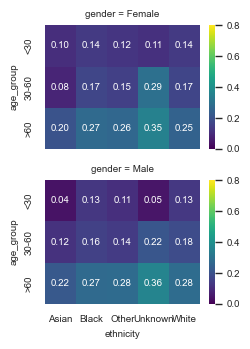

In [33]:
fig = plot_selection_rate_heatmap_by_gender(
    df=df_plot_synth,
    gender_col='gender',
    x_col='ethnicity',
    y_col='age_group',
    value_col='selection_rate',
    height=3.5,
    width=2.5,
    custom_scale=(0, 0.8)
)
plt.show()
if SAVE_FIGURES:
    fname = f'bias_ml_fairness_synth.tiff'
    fullpath = FIG_DIR / f'{fname}'
    fig.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.close(fig)

In [55]:
# Dataframes kombinieren
df_synth = df_metrics_synth.copy()
df_synth['Dataset'] = 'Synthetic'

df_real = df_metrics_real.copy()
df_real['Dataset'] = 'Real'

df_combined = pd.concat([df_synth, df_real])
if SAVE_FIGURES:
    fname = f'bias_ml_fairness_combined.csv'
    fullpath = RES_DIR / f'{fname}'
    df_combined.to_csv(
        fullpath,
        index=False,
        sep=';',
        decimal=',',
        encoding='utf-8'
    )
    print(f"CSV gespeichert unter: {fullpath}")

CSV gespeichert unter: results\bias_ml_fairness_combined.csv


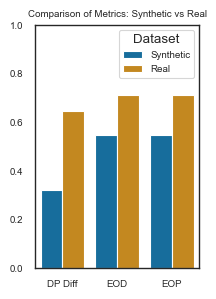

In [35]:


# Grouped Bar Chart
# plt.figure(figsize=(6, 6))
fig, ax = plt.subplots(figsize=(2.1, 3))
sns.barplot(data=df_combined, x='Metric', y='Value', hue='Dataset')

plt.title('Comparison of Metrics: Synthetic vs Real')
plt.xticks(rotation=20)
label_map = {
        "Demographic Parity Difference": "DP Diff",
        "Equalized Odds Difference":    "EOD",
        "Equal Opportunity Difference": "EOP",
    }

locs = ax.get_xticks()  # aktuelle Tick-Positionen auslesen
raw_labels = [l.get_text() for l in ax.get_xticklabels()]
new_labels = [label_map.get(lbl, lbl) for lbl in raw_labels]
ax.set_xticks(locs)  # FixedLocator setzen
# ax.set_xticklabels(new_labels, rotation=45, ha='right')
ax.set_xticklabels(new_labels, rotation=0)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.legend(title='Dataset', loc='upper right')
plt.tight_layout()
plt.show()
if SAVE_FIGURES:
    fname = f'bias_ml_fairness_comparison.tiff'
    fullpath = FIG_DIR / f'{fname}'
    fig.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.close(fig)

# SHAP
## Reales Modell

In [56]:
importances = best_model_real.named_steps["clf"].feature_importances_
feat_names  = best_model_real.named_steps["prep"].get_feature_names_out()
pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)

X_hold_trans = best_model_real.named_steps["prep"].transform(X_holdout)

if hasattr(X_hold_trans, "toarray"):
    X_hold_trans = X_hold_trans.toarray()
X_hold_trans = X_hold_trans.astype(np.float64)

feat_names  = best_model_real.named_steps["prep"].get_feature_names_out()
X_shap      = pd.DataFrame(X_hold_trans, columns=feat_names)
explainer   = shap.TreeExplainer(best_model_real.named_steps["clf"])
shap_values_real = explainer(X_shap, approximate=True)   

In [37]:
print(X_shap.columns.tolist())

['num__age', 'num__temperature', 'num__heart_rate', 'num__respiratory_rate', 'num__oxygen_saturation', 'num__systolic_bp', 'num__diastolic_bp', 'cat__gender_F', 'cat__gender_M', 'cat__ethnicity_Asian', 'cat__ethnicity_Black', 'cat__ethnicity_Other', 'cat__ethnicity_Unknown', 'cat__ethnicity_White', 'cat__night_arrival_False', 'cat__night_arrival_True', 'cat__weekend_arrival_False', 'cat__weekend_arrival_True', 'cat__chief_complaint_Other', 'cat__chief_complaint_aaa', 'cat__chief_complaint_abdo pain', 'cat__chief_complaint_abdominal distention', 'cat__chief_complaint_abdominal pain', 'cat__chief_complaint_abdominal pain chest pain', 'cat__chief_complaint_abdominal pain dizziness', 'cat__chief_complaint_abdominal pain dyspnea', 'cat__chief_complaint_abdominal pain hypotension', 'cat__chief_complaint_abdominal pain nausea', 'cat__chief_complaint_abdominal pain weakness', 'cat__chief_complaint_abdominal painnv', 'cat__chief_complaint_abnormal ct', 'cat__chief_complaint_abnormal ekg', 'cat_

In [57]:
# plt.figure(figsize=(5, 6))

X_shap_renamed = X_shap.rename(
    columns=lambda c: c.split('__', 1)[1] if '__' in c else c
)

shap.summary_plot(
    shap_values_real.values[:, :, 1],
    X_shap_renamed,
    show=False,
    max_display=10 # Standardmäßig werden 20 angezeigt
)

fig = plt.gcf()
fig.set_size_inches(7.2, 4)

plt.tight_layout()
# plt.show()
if SAVE_FIGURES:
    fname = 'bias_ml_SHAP_real.tiff'
    fullpath = FIG_DIR / fname
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.close()

Abbildung gespeichert unter: figures\bias_ml_SHAP_real.tiff


## Synthetisches Modell

In [58]:
importances = best_model_synth.named_steps["clf"].feature_importances_
feat_names  = best_model_synth.named_steps["prep"].get_feature_names_out()
pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)

X_hold_trans = best_model_synth.named_steps["prep"].transform(X_holdout)

if hasattr(X_hold_trans, "toarray"):
    X_hold_trans = X_hold_trans.toarray()
X_hold_trans = X_hold_trans.astype(np.float64)

feat_names  = best_model_synth.named_steps["prep"].get_feature_names_out()
X_shap      = pd.DataFrame(X_hold_trans, columns=feat_names)
explainer   = shap.TreeExplainer(best_model_synth.named_steps["clf"])
shap_values_real = explainer(X_shap, approximate=True)   

In [59]:
# plt.figure(figsize=(5, 6))

X_shap_renamed = X_shap.rename(
    columns=lambda c: c.split('__', 1)[1] if '__' in c else c
)

shap.summary_plot(
    shap_values_real.values[:, :, 1],
    X_shap_renamed,
    show=False,
    max_display=10 # Standardmäßig werden 20 angezeigt
)

fig = plt.gcf()
fig.set_size_inches(7.2, 4)

plt.tight_layout()
# plt.show()
if SAVE_FIGURES:
    fname = 'bias_ml_SHA_synth.tiff'
    fullpath = FIG_DIR / fname
    plt.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.close()

Abbildung gespeichert unter: figures\bias_ml_SHA_synth.tiff


# LIME

### Identifying suited Subjects
E.g. comparing two persons ho have a great difference between icu-admission prediction.
- Highest prediction for ICU admission is in Female, Unknown, >60
- Lowest in Male, Asian, <30
#### Female, Unkown, >60

In [39]:
female_unknown_over_60 = df_holdout[
    (df_holdout['gender'] == 'F') &
    (df_holdout['age'] > 60) &
    (df_holdout['ethnicity'] == 'Unknown') &
    (df_holdout['icu_admission_24h'] == True)
]
# print(female_unknown_over_60.head())

# I randomly selected a row from that holdout subset: row 2518
print(X_holdout.iloc[[2518]]) # female, 75, unknown, ICU Admission = True

      age gender ethnicity consciousness_level  temperature  heart_rate  \
2518   75      F   Unknown                   A         36.8          55   

      respiratory_rate  oxygen_saturation  systolic_bp  diastolic_bp  \
2518                16                 99          149            60   

     news_score  night_arrival  weekend_arrival chief_complaint icd_block  
2518          0           True            False             sdh   S00-S09  


#### Male, Asian, <30

In [40]:
male_asian_under_60 = df_holdout[
    (df_holdout['gender'] == 'M') &
    (df_holdout['age'] < 60) &
    (df_holdout['ethnicity'] == 'Asian') &
    (df_holdout['icu_admission_24h'] == False)
]
# print(male_asian_under_60.head())

# I randomly selected a row from that holdout subset: row 416
print(X_holdout.iloc[[416]]) # male, 58, asian, ICU Admission = False

     age gender ethnicity consciousness_level  temperature  heart_rate  \
416   58      M     Asian                   A         37.0          98   

     respiratory_rate  oxygen_saturation  systolic_bp  diastolic_bp  \
416                18                100          145            79   

    news_score  night_arrival  weekend_arrival      chief_complaint icd_block  
416          1          False            False  abnormal lab values   K70-K77  


In [41]:
# Training-Daten nach Preprocessing (dense Array)
# X_train_prep = best_model_real.named_steps['prep'].transform(X_real).toarray()
X_train_prep = best_model_real.named_steps['prep'].transform(X_real)
feature_names = best_model_real.named_steps['prep'].get_feature_names_out()

explainer = LimeTabularExplainer(
    training_data = X_train_prep,
    feature_names = feature_names,
    class_names   = ['no_ICU', 'ICU'],
    mode          = 'classification',
    discretize_continuous = True
)


In [42]:
# Beispiel-Patient aus df_holdout
# 2518: high ICU adm prediction     416: low ICU adm prediction
i = 416
x_instance = best_model_real.named_steps['prep'].transform(X_holdout.iloc[[i]])[0]
predict_fn = best_model_real.named_steps['clf'].predict_proba

lime_exp = explainer.explain_instance(
    data_row   = x_instance,
    predict_fn = predict_fn,
    num_features=len(feature_names)
)

In [43]:
explanation_list = lime_exp.as_list(label=1)
feature_names = best_model_real.named_steps['prep'].get_feature_names_out()
x_values = x_instance
active_features = [(name, val) for name, val in zip(feature_names, x_values) if val != 0]

active_data = []
for feat_name, val in active_features:
    match = [entry for entry in explanation_list if feat_name in entry[0]]
    if match:
        active_data.append({
            'Feature': feat_name,
            'Wert': val,
            'LIME_Beitrag': match[0][1],
            'Typ': 'Aktiv'
        })
    else:
        active_data.append({
            'Feature': feat_name,
            'Wert': val,
            'LIME_Beitrag': 0.0,
            'Typ': 'Aktiv (kein direkter LIME-Beitrag)'
        })

already_included = [feat['Feature'] for feat in active_data]
top10_extra = sorted(explanation_list, key=lambda x: abs(x[1]), reverse=True)

extra_data = []
for feature_desc, lime_value in top10_extra:
    if not any(active_name in feature_desc for active_name in already_included):
        extra_data.append({
            'Feature': feature_desc,
            'Wert': None,
            'LIME_Beitrag': lime_value,
            'Typ': 'Top10 Zusatz'
        })
    if len(extra_data) == 10:
        break
df_lime = pd.DataFrame(active_data + extra_data)

In [44]:
df_lime = df_lime.sort_values('LIME_Beitrag')
df_lime['Ist_aktiv'] = df_lime['Wert'].notna()

max_abs = df_lime['LIME_Beitrag'].abs().max()
vmin, vmax = -max_abs, max_abs

norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = cm.RdBu_r

# Alpha-Werte vektoriell
# alphas = np.where(df_lime['Ist_aktiv'], 1.0, 0.75)
# hatches = np.where(df_lime['Ist_aktiv'], '', '//')
lines = np.where(df_lime['Ist_aktiv'], 2.5, 0.5)

# Farben vektoriell anhand der neuen Norm
farbwerte = cmap(norm(df_lime['LIME_Beitrag']))



## Plot

In [45]:
df_lime['Feature'] = df_lime['Feature'].str.replace(r'^(?:cat__|num__|ord__)', '', regex=True)


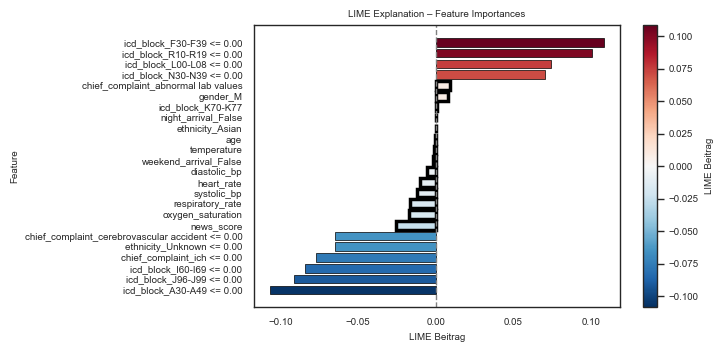

In [46]:
# Plot
plt.rcParams.update({'font.size': 6})
fig, ax = plt.subplots(figsize=(7.2, 3.5))
for feature, wert, color, line in zip(df_lime['Feature'],
                                       df_lime['LIME_Beitrag'],
                                       farbwerte,
                                       lines):
    ax.barh(feature, wert, color=color, edgecolor='black', linewidth=line, alpha=1.0)

# Null-Linie zur Orientierung
ax.axvline(0, color='grey', linestyle='--', linewidth=1)

# Farbskala hinzufügen
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('LIME Beitrag')

ax.set_title('LIME Explanation – Feature Importances')
ax.set_xlabel('LIME Beitrag')
ax.set_ylabel('Feature')
plt.tight_layout()
if SAVE_FIGURES:
    fname = f'bias_ml_LIME_patid_{i}.tiff'
    fullpath = FIG_DIR / fname
    fig.savefig(
        fullpath,
        dpi=300,
        format='tiff',
        bbox_inches='tight',
        pil_kwargs={'compression': 'tiff_lzw'}
    )
    print(f"Abbildung gespeichert unter: {fullpath}")
plt.show()